In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from collections import Counter
import json

# Data Preprocessing

In this exploratory data analysis, I looked at the data about the authors (the one who posts the thread), which are from 'submission_info.txt'

In [13]:
#info = pd.read_table('submission_info.txt')

As shown above, 'submission_info.txt' contains the submission ID, subreddit, thread title, author, number of comments, whether is is NSFW, score (which is defined as upvote - downvote), percentage of upvoted and its original url.

In [14]:
#info.head()

,SUBMISSION_ID,SUBREDDIT,TITLE,AUTHOR,#_COMMENTS,NSFW,SCORE,UPVOTED_%,LINK
0,t3_e7gje4,houston,downtown houston at sunset,adamisraelvaladez,32,NaN,952,0.97,/r/houston/comments/e7gje4/downtown_houston_at...
1,t3_d8vv6h,ReagentTesting,Mescaline Liebermann inconsistency,drugsmom,0,NaN,2,1.00,/r/ReagentTesting/comments/d8vv6h/mescaline_li...
2,t3_6gdv4s,legaladvice,What does this mean?,Alreadyownanacxount,3,NaN,0,0.33,/r/legaladvice/comments/6gdv4s/what_does_this_...
3,t3_bsh6pw,analog,untitled | nikon f100 | ilford hp5,24rocketman,43,NaN,1666,0.99,/r/analog/comments/bsh6pw/untitled_nikon_f100_...
4,t3_1xuutf,PS4,Unlimited ps+ trials,noahtessier,1,NaN,0,0.18,/r/PS4/comments/1xuutf/unlimited_ps_trials/


As an initial analysis, I focused on the author and the subreddit of each threads as I am interested in whether there are any underlying structures between author and subreddit. As each subreddit correponds to a specific topic, I would expect most authors only post in subreddits they are interested in rather than post in random subreddits. 

In this exploratory data analysis, I chose the top 1000 authors (in terms of submission) and top 1000 subreddits (in terms of submission) as a starting point and formed a 1000x1000 matrix where the (i,j)-th term is the frequency of ith author submitted to jth subreddit.

The following are the codes that generate the frequency matrix. It is time-consuming so I have stored the resulting dictionary in a json file


author_counter = Counter(info['AUTHOR'])
sub_counter = Counter(info['SUBREDDIT'])

#the first three authors are trivial: NaN, deleted and autoModerator
author1000 = author_counter.most_common(1003)[3:] 
sub1000 = sub_counter.most_common(1000)

with open('author1000.json', 'w') as fp: 
    json.dump(author1000, fp)
    
with open('sub1000_author.json', 'w') as fp: 
    json.dump(sub1000, fp)

"""

author1000_counter = {}

for i, author in enumerate(author1000):
    author1000_counter[author[0]] = Counter(info[info['AUTHOR'] == author[0]]['SUBREDDIT'])
    
with open('author1000_count.json', 'w') as fp:
    json.dump(author1000_counter, fp)
"""

In [2]:
with open('author1000.json') as f:
    author1000 = json.load(f)

with open('sub1000_author.json') as f:
    sub1000 = json.load(f)

with open('author1000_count.json') as f:
    author1000_count = json.load(f)

In [3]:
freq = np.zeros((1000,1000))

for i, author in enumerate(author1000):
    for j, sub in enumerate(sub1000):
        if sub[0] in author1000_count[author[0]]:
            freq[i,j] = author1000_count[author[0]][sub[0]]

In [4]:
np.sum(freq!=0)/(1000*1000)

0.024747

As shown above, only 2.5% of the entries are nonzero. The resultant matrix is very sparse. This shows that the each of the top1000 authors only submits to a small number of subreddits respectively.

# Principle component analysis

In this session, I conducted dimension reduction on the frequency matrix. Before the SVD, I first normalized the frequency matrix for each author.

In [5]:
normalized_freq = np.zeros((1000,1000))

for i, author_freq in enumerate(freq):
    if sum(author_freq):
        normalized_freq[i] = author_freq/sum(author_freq)

Since the matrix is sparse, truncatedSVD is used instead of full SVD. 

In [6]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100)
svd.fit(normalized_freq.T)

explained_var_lst = np.cumsum(svd.explained_variance_ratio_/svd.explained_variance_ratio_.sum())

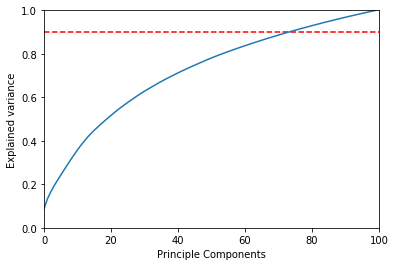

In [7]:
plt.plot(explained_var_lst)
plt.xlabel('Principle Components')
plt.ylabel('Explained variance')
plt.xlim([0,100])
plt.ylim([0,1])
plt.hlines(y=0.9,xmin=0,xmax=500,linestyle='dashed',color='r')
plt.show()

In [8]:
np.where(explained_var_lst>0.9)[0][0]

74

According to the plot, the top 74 principle components can explain 90% of the explained variance.

In [9]:
Z = svd.fit_transform(normalized_freq.T)

Below are the top 20 principle components, which represents the hidden structures among the top 1000 authors. The subreddit within each component are indeed related. Out of the 20 principle components, 40% are related to politics, while the rests are related to ACG, sports, pop culture and NSFW. 

In [10]:
from wordcloud import WordCloud

Author: Principle component 0
Tend to post in 


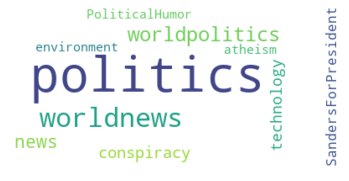

Author: Principle component 1
Tend to post in 


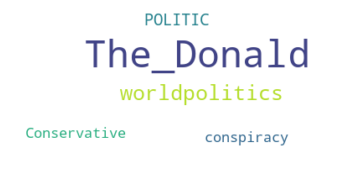

Author: Principle component 2
Tend to post in 


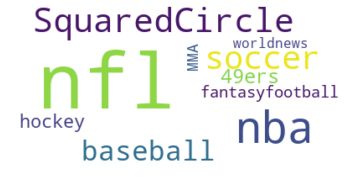

Author: Principle component 3
Tend to post in 


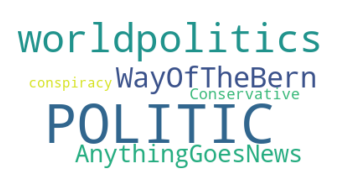

Author: Principle component 4
Tend to post in 


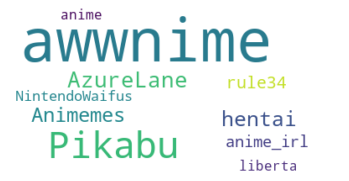

Author: Principle component 5
Tend to post in 


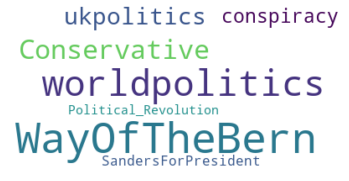

Author: Principle component 6
Tend to post in 


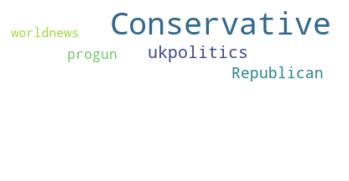

Author: Principle component 7
Tend to post in 


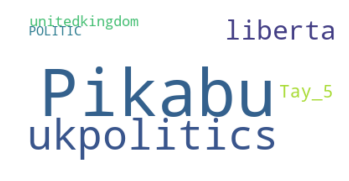

Author: Principle component 8
Tend to post in 


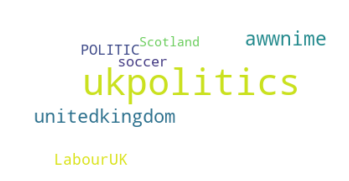

Author: Principle component 9
Tend to post in 


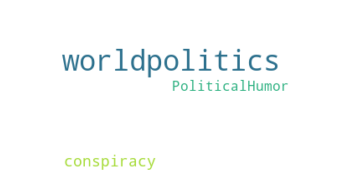

Author: Principle component 10
Tend to post in 


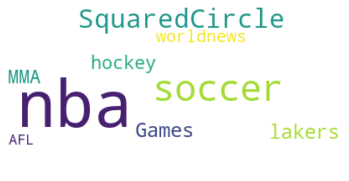

Author: Principle component 11
Tend to post in 


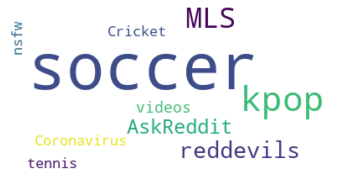

Author: Principle component 12
Tend to post in 


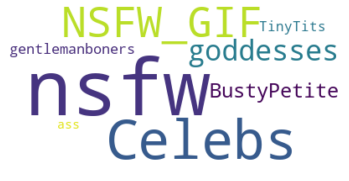

Author: Principle component 13
Tend to post in 


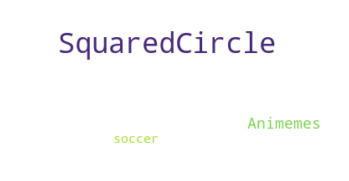

Author: Principle component 14
Tend to post in 


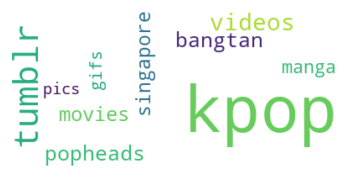

Author: Principle component 15
Tend to post in 


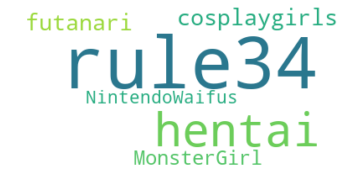

Author: Principle component 16
Tend to post in 


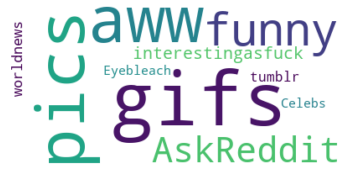

Author: Principle component 17
Tend to post in 


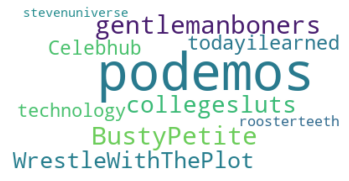

Author: Principle component 18
Tend to post in 


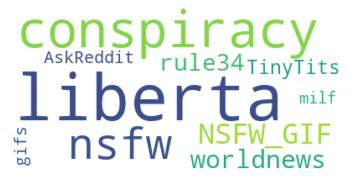

Author: Principle component 19
Tend to post in 


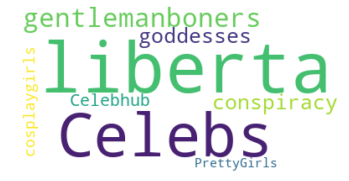

In [11]:
for i in range(20):
    Z_sort = np.argsort(Z[:,i])
    print('Author: Principle component ' + str(i))
    freq_dict = {}
    for j in range(1,11):
        sub_index = Z_sort[-j]
        sub_title = sub1000[sub_index][0]
        sub_weight = Z[sub_index,i]
        freq_dict[str(sub_title)] = sub_weight
        #print(str(sub_title) + ': ' + str(sub_weight))
    print('Tend to post in ')
    wordcloud = WordCloud(min_font_size=15,background_color='white')
    wordcloud.generate_from_frequencies(frequencies=freq_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    #print(' ')

This intial analysis reveals that there are latent structure of subreddit submissions. Instead of considering indiviual authors, we can consider them as different groups of authors, each posting in several related subreddits.